In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import librosa
import librosa.display
import numpy as np
import pandas as pd

import os
import pathlib
import matplotlib.pyplot as plt
import csv
import pickle

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

#Keras
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda

from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers

# Tensoflow
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend as K

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [3]:
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [4]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)

In [2]:
audio_path = '../Music_genre/genres/classical/classical.00001.wav'
x, fs = librosa.load(audio_path,mono=True, duration=5)
melspec = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=2048, hop_length=512)

In [3]:
melspec.shape

(128, 216)

In [4]:
melspec = librosa.power_to_db(melspec, ref=np.max)

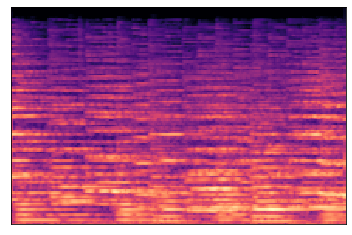

In [5]:
librosa.display.specshow(melspec, sr=fs)

In [ ]:
audio_path = '../Music_genre/genres/blues/blues.00001.wav'
x, fs = librosa.load(audio_path,mono=True, duration=5)
melspec = librosa.feature.melspectrogram(y=x, sr=fs, n_fft=2048, hop_length=512)

In [6]:
X = []
y_label = []

In [7]:
# Done this only once! just use the mel-spectrogram and pickle them
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:    
    for filename in os.listdir(f'./genres_aug_5s/{g}'):
        songname = f'./genres_aug_5s/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=4.5) #only load upto this much audio (in 5 seconds)
        melspec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512)
        melspec = librosa.power_to_db(melspec, ref=np.max)
        X.append(melspec)
        y_label.append(g)

In [9]:
# Done this once!
with open('data.pkl', 'wb') as f:
    pickle.dump(X, f)
    pickle.dump(y_label,f) # pickle reads data in order they're pickled

In [5]:
with open("data.pkl", "rb") as f:
    X = pickle.load(f)
    y_label = pickle.load(f)

In [6]:
len(X),len(y_label)

(6000, 6000)

In [7]:
X = np.array(X)

In [8]:
y_label = np.array(y_label)

In [9]:
y_label.shape, X.shape

((6000,), (6000, 128, 194))

In [10]:
# one-hot-encode the y label
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_label)

In [11]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, onehot_encoded, test_size=0.2, random_state=42)

In [13]:
X_train.shape, X_test.shape

((4800, 128, 194), (1200, 128, 194))

## Make sure keras is running on GPU

In [8]:
import multiprocessing

multiprocessing.cpu_count()

1

In [3]:
from tensorflow.python.client import device_lib
from keras import backend as K

Using TensorFlow backend.


In [4]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5930941025090459583
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13670889576819823008
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13192521336167736668
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11335721716579846908
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## 2. Parallel CRNN

Different genres have noticeable difference in mel-spectrograms and this gives us confidence to use CNN.<br>

1) **Why do we need to use both CNN and RNN?**
- CNN makes sense because spectrogram of a song looks like an image; spectrogram has a time component and RNN can do a better job identifying the short-term and longer-term temporal features

2) **Why parallel CRNN is perferred than CNN+RNN?**
- It can only summarize information from the ouputs of CNN. The temporal relationships of orginal musical signals are not perserved during operations of CNN.This model pass input spectrogram to both CNN and RNN layers in parallel, concatenating their output and sending this through a dense layer with softmax activation to perform activation.
- Similar accuracy but class-wise performance is very different.
- Reason for low accuracy without data augmentation: gets overfit very quickly

In [14]:
batch_size = 32
num_classes = 10
n_features = X_train.shape[1]
n_time = X_train.shape[2]

In [15]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
EPOCH_COUNT = 50
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(pool_4)
#     pool_5 = MaxPooling2D(pool_size_1)(conv_5)

    flatten1 = Flatten()(conv_5)
    
    ### Recurrent Block: 2D Max pooling of pool_size 4,2 to reduce the size of spectrogram before LSTM (speed up processing)
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer
    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
#     flatten2 = K.squeeze(pool_lstm1, axis = -1)
#     dense1 = Dense(dense_size1)(flatten)
    
    # Bidirectional GRU with 64 units
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(model_input, model_output)
    
#     opt = Adam(lr=0.001)
    opt = RMSprop(lr=0.0005)  # Optimizer
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [16]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 128
    n_frames = 194
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    input_shape = (n_frequency, n_frames, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.aug2.h5', monitor='val_accuracy', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [17]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [18]:
model, history  = train_model(X_train, y_train, X_test, y_test)

Building model...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 128, 194, 1)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 126, 194, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 63, 97, 16)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 61, 97, 32)   1568        max_pooling2d_1[0][0]            
__________________________________________________________________________

4800/4800 [==============================] - 14s 3ms/step - loss: 0.7452 - accuracy: 0.7456 - val_loss: 1.0285 - val_accuracy: 0.6383

Epoch 00020: val_accuracy did not improve from 0.63917
Epoch 21/50
4800/4800 [==============================] - 14s 3ms/step - loss: 0.7191 - accuracy: 0.7573 - val_loss: 1.0216 - val_accuracy: 0.6258

Epoch 00021: val_accuracy did not improve from 0.63917
Epoch 22/50
4800/4800 [==============================] - 14s 3ms/step - loss: 0.6835 - accuracy: 0.7635 - val_loss: 0.9734 - val_accuracy: 0.6567

Epoch 00022: val_accuracy improved from 0.63917 to 0.65667, saving model to ./models/parallel/weights.best.aug2.h5
Epoch 23/50
4800/4800 [==============================] - 14s 3ms/step - loss: 0.6453 - accuracy: 0.7821 - val_loss: 0.9238 - val_accuracy: 0.7017

Epoch 00023: val_accuracy improved from 0.65667 to 0.70167, saving model to ./models/parallel/weights.best.aug2.h5
Epoch 24/50
4800/4800 [==============================] - 14s 3ms/step - loss: 0.6227

In [14]:
dict_genres = {'blues':0, 'classical':1, 'country':2, 'disco':3, 
               'hiphop':4,'jazz':5, 'metal' :6, 'pop': 7, 'raggae':8, 'rock':9  }

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


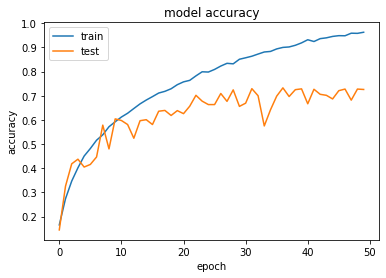

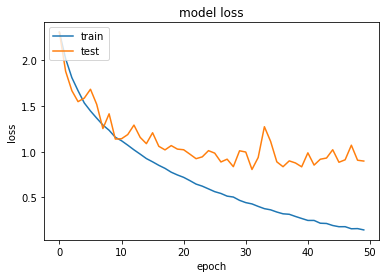

In [20]:
show_summary_stats(history) # GPU gives random seed in some way, so it's hard to reproduce the same accuracy.

In [21]:
X_test.shape, X_train.shape,y_test.shape

((1200, 128, 194), (4800, 128, 194), (1200, 10))

In [15]:
from keras.models import load_model

weights_path = 'models/parallel/weights.best.aug2.h5'
model = load_model(weights_path)

In [16]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis = 1)
X_test = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(1200,) (1200,)
              precision    recall  f1-score   support

       blues       0.78      0.70      0.74       143
   classical       0.83      0.92      0.87       125
     country       0.64      0.72      0.68       130
       disco       0.81      0.48      0.60       115
      hiphop       0.72      0.82      0.77       100
        jazz       0.82      0.86      0.84       112
       metal       0.92      0.92      0.92       118
         pop       0.64      0.86      0.74       125
      raggae       0.63      0.72      0.68       112
        rock       0.53      0.34      0.42       120

    accuracy                           0.73      1200
   macro avg       0.73      0.73      0.72      1200
weighted avg       0.73      0.73      0.72      1200



In [23]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.7258333333333333


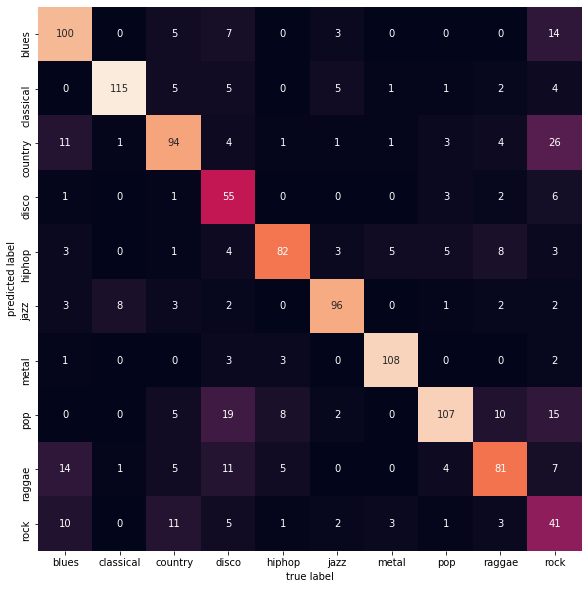

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(mat.T, square=True, annot=True, fmt='d',cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label')
# ax.set_ylim(len(harvest)-0.5, -0.5)

b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

In [32]:
cm = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

In [34]:
cm.diagonal()

array([0.6993007 , 0.92      , 0.72307692, 0.47826087, 0.82      ,
       0.85714286, 0.91525424, 0.856     , 0.72321429, 0.34166667])

## Visualize activations in different layers -2D CNN layers

In [24]:
from vis.visualization import visualize_activation
from vis.visualization import visualize_saliency
from vis.utils import utils
from keras import activations

In [25]:
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

### a. Filters for convolution block 1

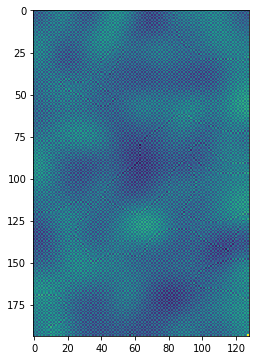

In [26]:
filters=[]
#layer_idx = utils.find_layer_idx(model, 'preds')
layer_idx = utils.find_layer_idx(model, 'conv_1')
# This is the output node we want to maximize.
for filter_idx in range(nb_filters1):
    #filter_idx = 1
    plt.rcParams['figure.figsize'] = (18, 6)
    img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
    filters.append(img)
    plt.imshow(img[..., 0].T)
    #lt.savefig(str(filter_idx)+'.png')

Num Filters is:  16
Stitched shape:  (261, 1587)


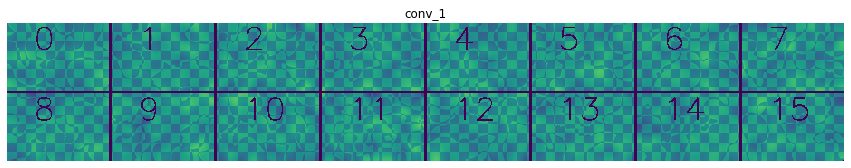

In [27]:
from vis.visualization import get_num_filters
import cv2

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv_1'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))
print("Num Filters is: ", filters[-1]+1)
# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,str(idx),(50,50), font, 2,(0,0,0),2) 
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)
stitched = stitched.reshape(stitched.shape[0], stitched.shape[1])
print("Stitched shape: ", stitched.shape)
plt.rcParams['figure.figsize'] = (15, 5)
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

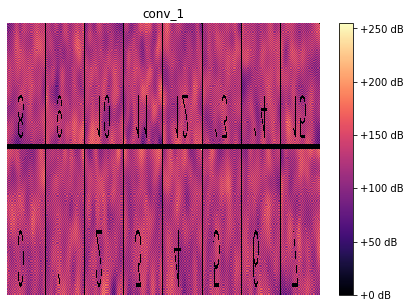

In [28]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.axis('off')
librosa.display.specshow(stitched, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
# plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Num Filters is:  64
Stitched shape:  (1059, 1587)


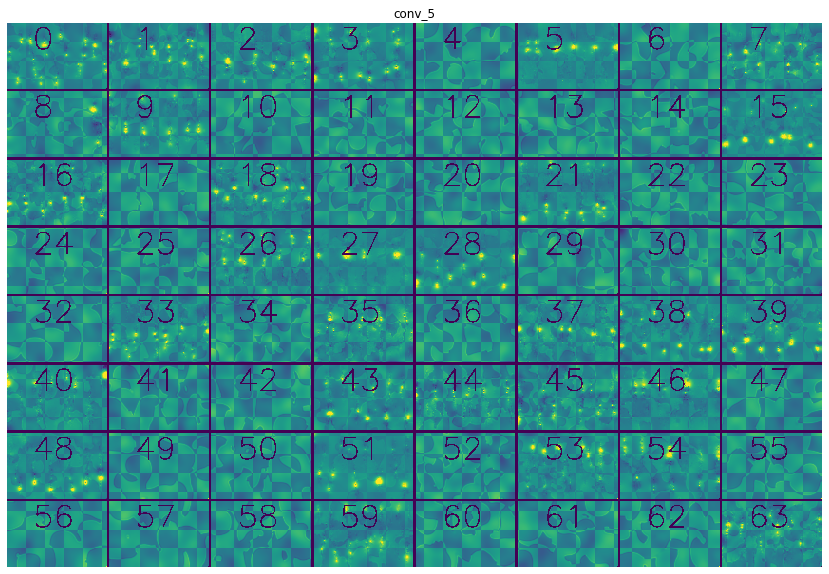

In [29]:
# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'conv_5'
layer_idx = utils.find_layer_idx(model, layer_name)

# Visualize all filters in this layer.
filters = np.arange(get_num_filters(model.layers[layer_idx]))
print("Num Filters is: ", filters[-1]+1)
# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img,str(idx),(50,50), font, 2,(0,0,0),2)   
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)
stitched = stitched.reshape(stitched.shape[0], stitched.shape[1])
print("Stitched shape: ", stitched.shape)
plt.rcParams['figure.figsize'] = (30, 10)
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

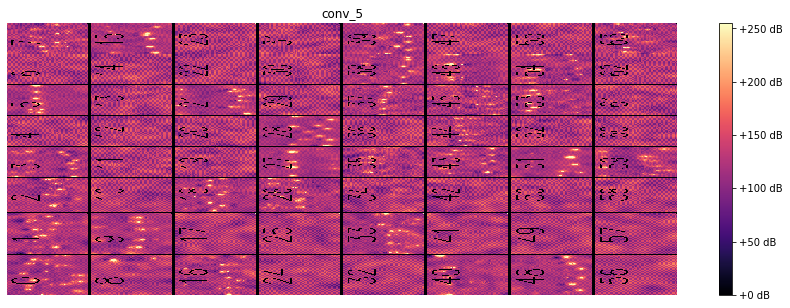

In [30]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.axis('off')
librosa.display.specshow(stitched.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
# plt.imshow(stitched)
plt.title(layer_name)
plt.show()